# Accessing OOI data with ooilab
By Sage Lichtenwalner, November 17, 2020

Accessing data from the OOI Data Portal (aka OOInet) is relatively straightforward, once you know the details for the instruments you need.  

Even better, with a bit of code, you can request, download and load high-res data without having to navigate through the Data Portal, or rely on its limited plotting capability.  This is especially useful if you want to create a script to download the latest data, or grab data from multiple instruments.  Either case isn't very practical to do by hand.

In the past, the examples I've written in Python have been very lengthy. But I've finally gotten around to creating a new python library, [ooilab](https://github.com/seagrinch/ooilab), which you can use to grab OOI data with just a few lines of code in your notebook.

In this notebook, we'll quickly demonstrate how you can use this new library.

## Let's get Started

First, as we normally do, let's setup our notebook for the Google Colab environment.

In [1]:
# Notebook Setup
import xarray as xr
!pip install netcdf4
import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## Importing ooilab
Our next step is to install and import the new **ooilab** library.  You can find more information about how to use the library on my [ooilab GitHub page](https://github.com/seagrinch/ooilab).

In [2]:
!pip install git+https://github.com/seagrinch/ooilab.git
import ooilab

  Cloning https://github.com/seagrinch/ooilab.git to /tmp/pip-req-build-x4po9qrc
  Running command git clone -q https://github.com/seagrinch/ooilab.git /tmp/pip-req-build-x4po9qrc
  Created wheel for ooilab: filename=ooilab-0.2-cp36-none-any.whl size=2577 sha256=6255bbbc1688df16fe0e7c65b04f42d274b088d887967487b6e4c5e920305070
  Stored in directory: /tmp/pip-ephem-wheel-cache-_x99eu94/wheels/7f/c9/1d/60f91d31a29c5e03e8bc9dd7a58918a976a3f2ffe1ffcb3ea1
Successfully built ooilab


If you plan on using the library to make data requests, you will first need to specify your API username and token, which you can find on the bottom of your "User Profile" page after logging in.  (Note, these are different from the username and password you use to log into the Data Portal.)

In [3]:
ooilab.API_USERNAME = ''
ooilab.API_TOKEN = ''

## Requesting Data from OOINet 
Now that we have the library installed, we can  use it to request data, using the `request_data()` function (go figure).

Let's grab the last 2 years of data from the 30m CTD at [Global Irminger Sea Flanking Mooring B](https://oceanobservatories.org/site/gi03flmb/).

In [34]:
# Data Request - This only needs to be run once
ooilab.request_data('GI03FLMB-RIM01-02-CTDMOG060',
                    'recovered_inst',
                    'ctdmo_ghqr_instrument_recovered',
                    '2018-01-01T00:00:00.000Z',
                    '2021-01-01T00:00:00.000Z')

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20201117T152256970Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

Let's save that url for future reference, so we don't have to rerun this function if we restart the notebook.  I would also recommend commenting out the above line to prevent the code from accidentally running again.

In [4]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20201117T152256970Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

## Loading Data Files
Once the Data Portal has generated your dataset (you should get an email) you can load it.  This is a two-step process.  

1. First we run `get_filelist(url)` to filter out just the files we need from the Thredds url we got earlier.
2. Then we can pass that list to `xarray.open_mfdataset()` like any other list of files.

In [5]:
# Grab the list of files
flist = ooilab.get_filelist(url)
flist

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20201117T152256970Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0004_GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20180101T000001-20180611T193001.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20201117T152256970Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0005_GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20180611T144501-20190810T120001.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20201117T152256970Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0006_GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered_20190808T133001-20200825T154501.nc#fillmismatch']

In [6]:
# Load the dataset
data = xr.open_mfdataset(flist).swap_dims({'obs': 'time'}).sortby('time')

## Plotting Fun
Let's make a quick plot of the data.

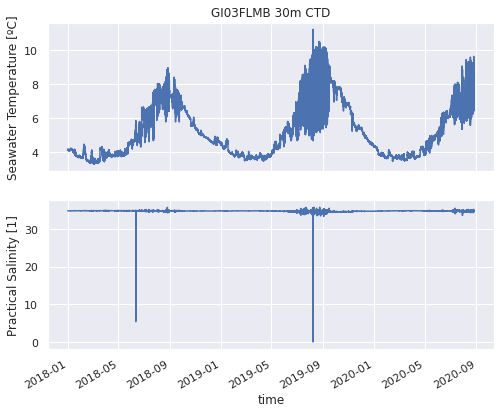

In [7]:
# Quickplot
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6))
data['ctdmo_seawater_temperature'].plot(ax=ax1)
data['practical_salinity'].plot(ax=ax2)
ax1.set_xlabel(None);
ax1.set_title('GI03FLMB 30m CTD');

## Cleaning Your Data
As we can see, there are some spikes in the salinity dataset.  Luckily, ooilab comes with two quick functions you can use to clean your data.
* reject_outliers(data, sd=5)
* clean_data(data, min=0, max=100, sd=5)

Let's use the clean_data function, which also calls reject_outliers, to clean this up using the default settings.


In [8]:
data['practical_salinity'] = ooilab.clean_data(data['practical_salinity'])

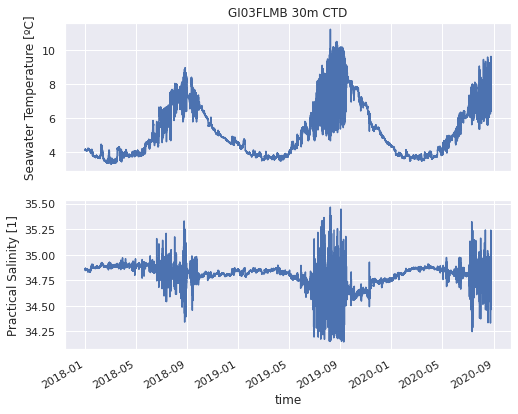

In [9]:
# Quickplot
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6))
data['ctdmo_seawater_temperature'].plot(ax=ax1)
data['practical_salinity'].plot(ax=ax2)
ax1.set_xlabel(None);
ax1.set_title('GI03FLMB 30m CTD');

## It's about Averaging

Finally, let's run a quick daily average of these two variables.

In [10]:
avg_data = data[['ctdmo_seawater_temperature','practical_salinity']].resample(time='1D').mean()

And now let's make a final plot.

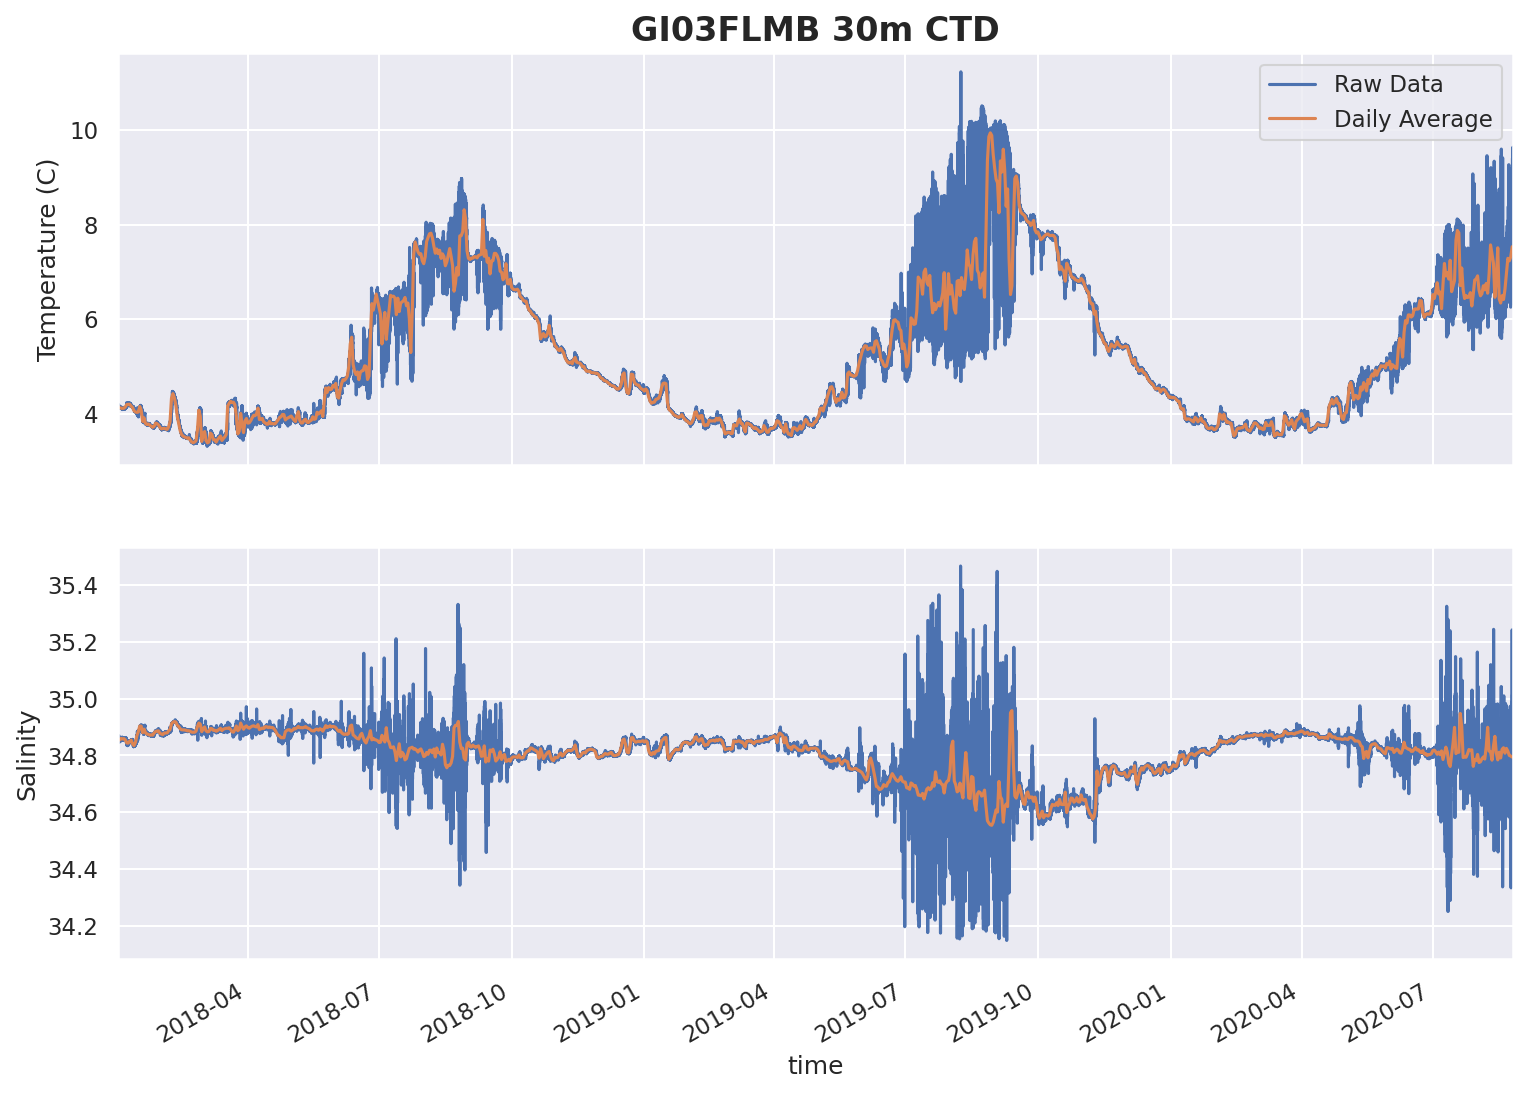

In [13]:
# Quickplot
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(12,8),dpi=150)
data['ctdmo_seawater_temperature'].plot(ax=ax1,label='Raw Data')
data['practical_salinity'].plot(ax=ax2)
avg_data['ctdmo_seawater_temperature'].plot(ax=ax1,label='Daily Average')
avg_data['practical_salinity'].plot(ax=ax2)

ax1.legend(loc=1)
ax1.set_xlim([data.time.min(),data.time.max()])
ax1.set_xlabel(None);
ax1.set_ylabel('Temperature (C)')
ax2.set_ylabel('Salinity')
ax1.set_title('GI03FLMB 30m CTD',fontweight='bold',fontsize=16);
plt.savefig('Irminger.png');